# Causal Emergence - example usage

In [1]:
import os
# If you are running this from ~/python_scripts/mycode.py
# change directory to the root of the repository
# All utils assume that the working directory is the root directory of the github folder
os.chdir('../')

import sys
sys.path.insert(0, os.path.join(os.getcwd(),'utils'))

# import local utils
from causal_emergence import effective_information, causal_emergence, causal_emergence_spectral

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

*Causal emergence* is when the coarse-grained network has more *effective information* ($EI$) than the micro-scale network. This means:

1. Calculate the $EI$ of the micro-scale network.
2. Propose a candidate micro-macro mapping and calculate its $EI$.
3. If $EI_{macro} > EI_{micro}$, accept the mapping.
4. Continue steps 2 & 3 until stop.

In [3]:
# make an example network
G = nx.karate_club_graph()

In [4]:
print("The effective information (EI) of G (microscale) is", effective_information(G))

The effective information (EI) of G (microscale) is 2.3766489441245473


In [5]:
mapping, weighted_edgelist = causal_emergence(G)
# CE = causal_emergence(G,dev=True)
G_macro = nx.from_pandas_edgelist(weighted_edgelist, edge_attr='weight')

In [6]:
print("Microscale EI =",effective_information(G))
print("Macroscale EI =",effective_information(G_macro))

Microscale EI = 2.3766489441245473
Macroscale EI = 2.6828059459378855


In [7]:
# if you're loading a vector of macro-mappings, assume that the index is the micro id

In [8]:
# Let's take a look at the resulting mapping. All values of size > largest node id are macronodes.
mapping

,micro,macro
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,34
8,8,35
9,9,35


In [9]:
G_macro.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 31, 34, 35, 36, 30, 27, 28, 32, 16, 15, 33, 20, 23, 25, 29, 24, 26))

In [10]:
import matplotlib as mpl
def visualize_micro_macro(G_micro, G_macro, macro_mapping,
                          ns=50, lw=1.5, ec='.5', nc='w', nec='steelblue',
                          macroscale_colorful=True, macroscale_cmap='Set2',
                          macro_labeling_match=True):
    """
    Visualize microscale and macroscale networks side by side.

    Parameters:
    - G_micro (nx.Graph): Microscale network (a NetworkX graph).
    - G_macro (nx.Graph): Macroscale network (a NetworkX graph).
    - macro_mapping (pd.DataFrame): Micro-Macro mapping.
    - ns (int, optional): Node size for visualization. Default is 50.
    - lw (float, optional): Linewidth for edges. Default is 1.5.
    - ec (str, optional): Edge color. Default is '.5' (gray).
    - nc (str, optional): Node color. Default is 'w' (white).
    - nec (str, optional): Node edge color. Default is 'steelblue'.
    - macroscale_colorful (bool, optional): Whether to color macroscale nodes
                        differently if they are not in the microscale network.
                        Default is True, which assigns different colors to
                        macroscale nodes not present in the microscale network.
    - macro_labeling_match (bool, optional): Does the labeling scheme match
                        between the microscale and macroscale? I.e. do micro
                        nodes in the macro scale share the same label as their
                        corresponding node in the microscale network?

    Returns:
    - None: This function plots and displays the microscale
            and macroscale networks side by side.
    """

    # Create a figure with two subplots for microscale and macroscale networks
    fig, ax = plt.subplots(1,2,figsize=(10,4.5),dpi=200)

    # Position the nodes of the microscale network using a spring layout
    pos_micro = nx.spring_layout(G_micro)

    # Relabel nodes in order to visualize
    if type(macro_mapping) == dict:
        macro_mapping = pd.DataFrame({"micro":list(macro_mapping.keys()),
                                      "macro":list(macro_mapping.values())})

#     if type(macro_mapping) != pd.DataFrame:

    if not macro_labeling_match:
        macro_labels = np.unique(sorted(macro_mapping['macro'].values))
        G_macro = nx.relabel_nodes(G_macro,
                                   dict(zip(list(G_macro.nodes()),
                                                 macro_labels))).copy()

    # for positioning the macroscale network, our go-to will be 
    # to first assign (and fix) the positions of the micronodes
    # that were not coarse-grained to their original pos_micro value
    fixed_macro = [i for i in pos_micro.keys()
                   if i in list(G_macro.nodes())]

    # Initialize macroscale nodes based on the microscale positions or random positions
    macro_init = {i:pos_micro[i] if i in list(pos_micro.keys())
                  else np.random.rand(2) for i in G_macro.nodes()}
    pos_macro = nx.spring_layout(G_macro, pos=macro_init, fixed=fixed_macro)

    G_cg = nx.to_undirected(G_macro)

    # plot microscale network
    nx.draw(G_micro, pos_micro, ax=ax[0],
            node_size=ns,
            linewidths=lw,
            edge_color=ec,
            node_color=nc,
            edgecolors=nec)
    
    # plot macroscale network
    ncs = ['limegreen' if i not in G_micro.nodes() else nc for i in G_cg.nodes()]
    if macroscale_colorful:
        macro_not_in_micro = [i for i in G_cg.nodes() if i not in list(G_micro.nodes())]
        n_macro = len(macro_not_in_micro)
        new_colors = mpl.cm.get_cmap(macroscale_cmap)(np.linspace(0,1,n_macro))
        ncs = [nc for i in G_cg.nodes()]
        z = 0
        for ix, nc_i in enumerate(list(G_cg.nodes())):
            if nc_i in macro_not_in_micro:
                ncs[ix] = new_colors[z]
                z+=1

    nx.draw(G_cg, pos_macro, ax=ax[1],
            node_size=[ns*4 if i not in G_micro.nodes() else ns for i in G_cg.nodes()],
            edge_color=ec,
            linewidths=lw,
            node_color=ncs,
            edgecolors=['k' if i not in G_micro.nodes()
                        else nec for i in G_cg.nodes()])

    ax[0].set_title('Original network')
    ax[1].set_title('Coarse-grained network')

    plt.show()

/usr/local/anaconda3/envs/covid/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


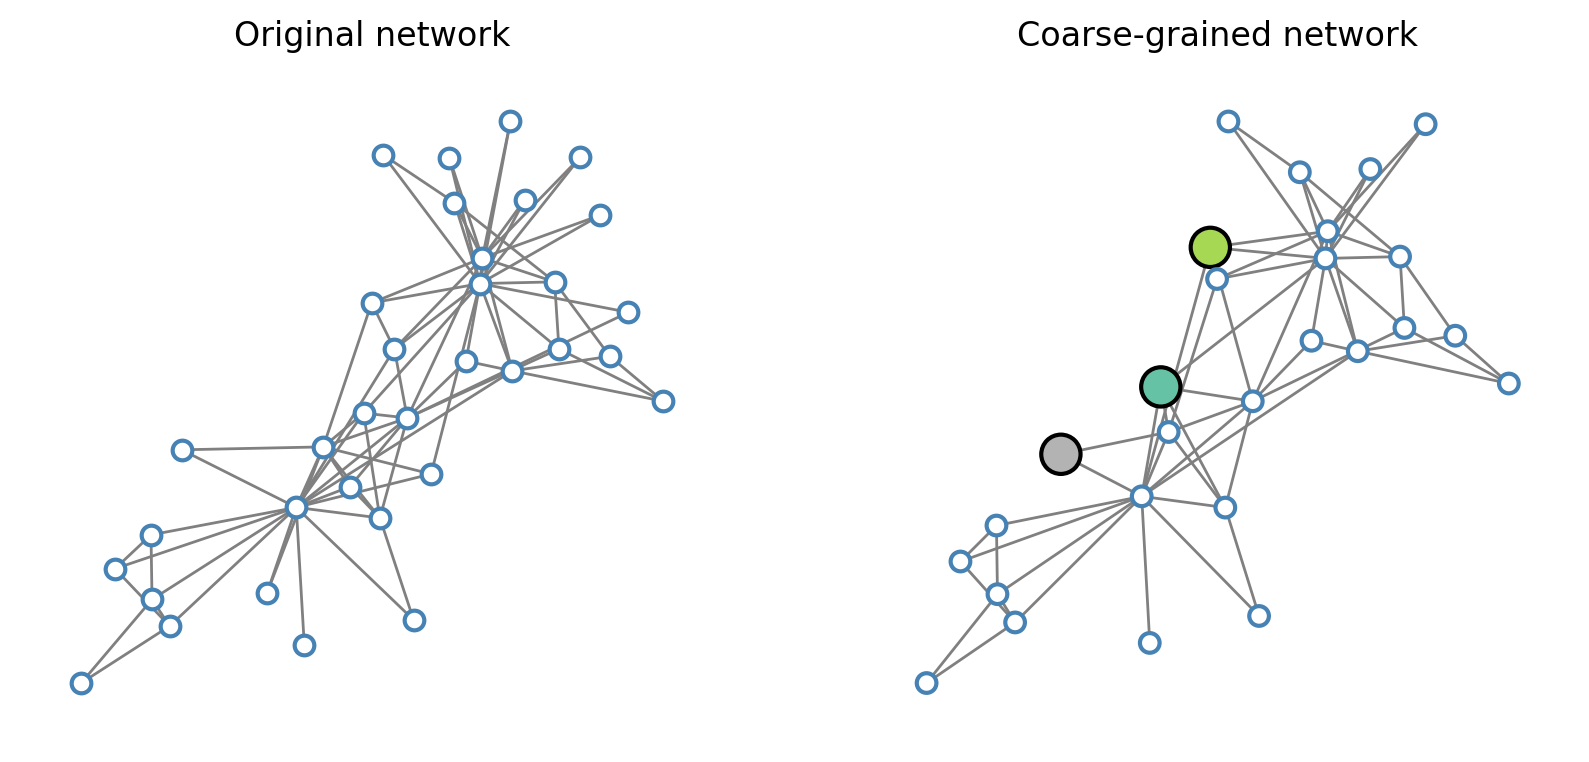

In [11]:
visualize_micro_macro(G, G_macro, mapping)